# Machine Learning
# TP3 Logistic Regression

In the first section of this practical work we will explore logistic regression, which is used for classification tasks. In a second part we will move to its multi-class generalization, SoftMax regression, and apply it to the MNIST dataset.

## Part 1: Logistic regression

Loigistic regression is useful of binary classification with a {0, 1} output. It relies on the sigmoid function
$$ \sigma_w(x) = \frac{1}{1+e^{-w x}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

Text(0.5, 1.0, 'Sigmoid function')

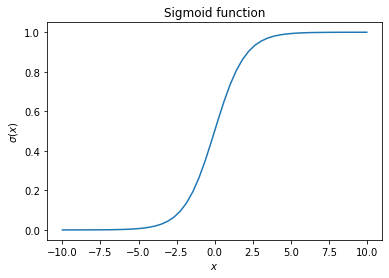

In [3]:
# Plot the sigmoid function
x = np.linspace(-10, 10)
y = sigmoid(x)
plt.plot(x, y)
plt.xlabel("$x$")
plt.ylabel("$\sigma(x)$")
plt.title("Sigmoid function")

### Generating Data

Here we generate two data set of 5000 samples. Each sample is a point distributed via a bivariate distribution. Mean are (0,0) and (1, 4). `[[1, .75], [.75, 1]]` is the covariance matrix. Both data set follows it. Samples generated with the first distribution are labelled $0$ and the others are labelled $1$.

In [4]:
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

Text(0, 0.5, '$y$')

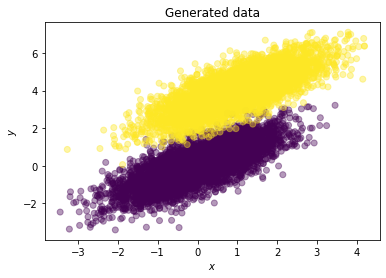

In [5]:
# Plot generated data
plt.figure(figsize=(6,4))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)
plt.title("Generated data")
plt.xlabel("$x$")
plt.ylabel("$y$")

## Maximizing the Likelihood

The estimated probability of "success" ie. $y_i = 1$, is given by the sigmoid function: $$P_{\rm est}(y_i=1 \vert x_i, {\bf w}) = \frac 1{1+ e^{-{\bf w} \cdot {\bf x_i}}}$$
The estimated probability of "failure", ie. $y_i=0$ is given by the complementary probability:
$$P_{\rm est}(y_i=0 \vert x_i, {\bf w}) = \frac {e^ {-{\bf w} \cdot {\bf x_i}}}{1+ e^{- {\bf w} \cdot {\bf x_i}}}$$

We derive the cross-entropy $H(P_{\rm true}, P_{\rm est})$:

$$ H(P_{\rm true}, P_{\rm est}) = - \sum_{i=1}^{N} \sum_{l\in[0, 1]} P_{\rm true}(y_i=l) \ln P_{\rm est} (y_i=l \vert x_i, {\bf w}) $$

Let us first notice that 
$$P_{\rm true}(y_i=1) = \cases{ 0 \text{ if } y_i=0 \\ 1 \text{ if } y_i=1}$$
Hence we can write $P_{\rm true}(y_i=1) = y_i$. This yields $P_{\rm true}(y_i=0) = 1-y_i$. 

$$\begin{align}
H(P_{\rm true}, P_{\rm est}) &= - \sum_{i=1}^{N} (1-y_i) \left[ - {\bf w \cdot x_i} - \ln (1 + e^{- {\bf w \cdot x_i}})\right] - y_i \ln (1 + e^{- {\bf w \cdot x_i}}) \\
 &= \sum_{i=1}^{N} (1-y_i) {\bf w \cdot x_i} + \ln (1 + e^{- {\bf w \cdot x_i}})
\end{align}
$$

We try to minimizing the cross-entropy, in other words to reduce the dissimilarity between the true probability $P_{\rm true}$ and the estimated one $P_{\rm est}$ of finding the label $y_i$.

The cross-entropy is equal to the negative log-likelihood: 
$$H(P_{\rm true}, P_{\rm est}) = - \ln \mathcal{L}$$ Best results are associated with minimum cross-entropy and maximum (log-)likelihood.

In [6]:
def cross_entropy(features, target, weights):
    """
    Return the averaged cross-entropy associated to the estimated weights.
    
    arg features: the samples array
    arg target: the label array
    arg weights: the estimated weights array
    
    return: a float 
    """
    assert features.shape[1] == len(weights)
    
    scores = np.dot(features, weights) #w * x_i
    a = np.dot(1 - target, scores)
    b = np.log(1 + np.exp(-scores))
    return np.mean(a + b)

In [7]:
def log_likelihood(features, target, weights):
    """
    Return the averaged log-likelihood associated to the estimated weights.
    
    arg features: the samples array
    arg target: the label array
    arg weights: the estimated weights array
    
    return: a float
    """
    return - cross_entropy(features, target, weights)

In [8]:
# Testing the function
w = np.array([0., 0.])
x = simulated_separableish_features
l = simulated_labels
# with w = 0, only the 'b' term remains in the sum, with b=log(2)
assert cross_entropy(x, l, w) == np.log(2)

## Calculating the gradient

We try to minimized the cross-entropy. For this goal we build its gradient:

$$ \begin{align}
\partial_{\bf w} H(P_{\rm true}, P_{\rm est}) &= \sum_{i=1}^{N} {\bf x_i} (1-y_i) - {\bf x_i} \frac{e^{- {\bf w \cdot x_i}}}{1+e^{- {\bf w \cdot x_i}}} \\
&= \sum_{i=1}^{N} {\bf x_i} \left( \sigma ({\bf x_i}) - y_i \right)
\end{align}$$

Or matricially:
$$ \partial_{\bf w} H(P_{\rm true}, P_{\rm est}) = {\bf X}^T ({\bf \hat{Y}} - {\bf Y})$$

In [9]:
def gradient(features, target, weights):
    """ 
    Return the (normalized) gradient of the cross-entropy 
    with respect to the weigths.
    
    arg features: the samples array;
    arg target: the label array;
    arg weights: the estimated weight array
    """
    scores = np.dot(features, weights)
    return features.T @(sigmoid(scores) - target) / len(target)

In [10]:
print(gradient(x, l, w))

[-0.24658084 -1.00051367]


## Building the Logistic Regression Function

In order to minimize the loss function, we use gradient descent to find the best value for the weight parameter ${\bf w}$. Namely, $${\bf w^{t+1}} = {\bf w^t} - \eta \nabla_{\bf w} \mathrm{Loss}$$ where $\eta$ is a learning rate.

In [11]:
def add_intercept(features):
    """ 
    Add a new 1-filled column to the features array. 
    """
    ones = np.ones((features.shape[0], 1))
    return np.hstack((ones, features))

In [12]:
def logistic_regression(features, target, num_steps, learning_rate, 
                        verbose=False):
    """
    Update weights via a gradient descent method.
    
    arg features: the samples array;
    arg target: the label array;
    arg num_steps: the number of iterations. Since there is no 
        convergence criterion, it should be great enough to meet
        the global minimum
    arg learning_rate: the greater the learning rate, the bigger 
        the steps taken at each iteration in the weight space
    arg verbose: if True, print current cross-entropy every now and then
    
    return: an array of optimized weights. 
    """    
        
    weights = np.zeros((features.shape[1], ))
    history = np.empty((num_steps, features.shape[1]))
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)
        
        # Update weights 
        weights -= learning_rate * gradient(features, target, weights)
        
        history[step] = weights
        
        # Print Loss every so often
        if verbose and step % 10000 == 0:
            print(cross_entropy(features, target, weights))
            
    return weights, history

In [13]:
x_intercept = add_intercept(x)

In [15]:
w, h = logistic_regression(x_intercept, l, num_steps = 50000, learning_rate = 5e-1)

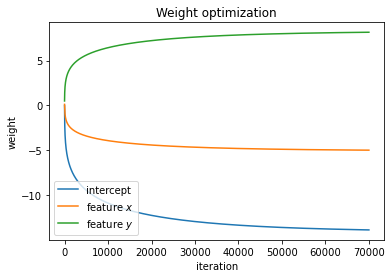

In [16]:
# Plot history
plt.plot(h[:, 0], label='intercept')
plt.plot(h[:, 1], label='feature $x$')
plt.plot(h[:, 2], label='feature $y$')
plt.xlabel("iteration")
plt.ylabel("weight")
plt.title("Weight optimization")
plt.legend()

In [17]:
print(w)

[-13.86069169  -4.97745522   8.15600611]


### Using `sklearn` built-in `LogisticRegression` class

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
LR = LogisticRegression(penalty='none', fit_intercept=True)
LRclf = LR.fit(x, l)
print(LRclf.intercept_, LRclf.coef_)

[-14.09231079] [[-5.05902155  8.28959202]]


*Comment*: our home-made weights are consistent with `sklearn` results, given the $0.5$ accuracy.

## What is the accuracy ?

In [20]:
# Predictions
def predict(features, weights):
    """ 
    Return the estimated labels of the features, 
    given the estimated feature weights.
    
    arg features: the samples array;
    arg weights: the array of estimated parameters;
        
    return: a ndarray of shape (len(features),) containing 
        the estimated label of each sample in `features`
    """   
    assert features.shape[1] == len(weights)
    
    scores = np.dot(features, weights)
    return np.round(sigmoid(scores))

In [21]:
def accuracy(pred_labels, true_labels):
    """
    Return the fraction of good estimations.
    
    arg pred_labels: the predicted label array
    arg true_labels: the true label array
    
    Both arrays must have the same shape.
    
    return: a float in [0; 1]
    """
    assert np.shape(pred_labels) == np.shape(true_labels)
    return (pred_labels == true_labels).mean()

Let us apply these functions to our data set:

In [23]:
pred = predict(x_intercept, w)
acc = accuracy(pred, l)
print("Accuracy: {0}".format(acc))

Accuracy: 0.9948


That's a good result, as expected given the data.

We check that the few mistakes are located between the clusters.

Text(0.5, 1.0, 'Misclassified points')

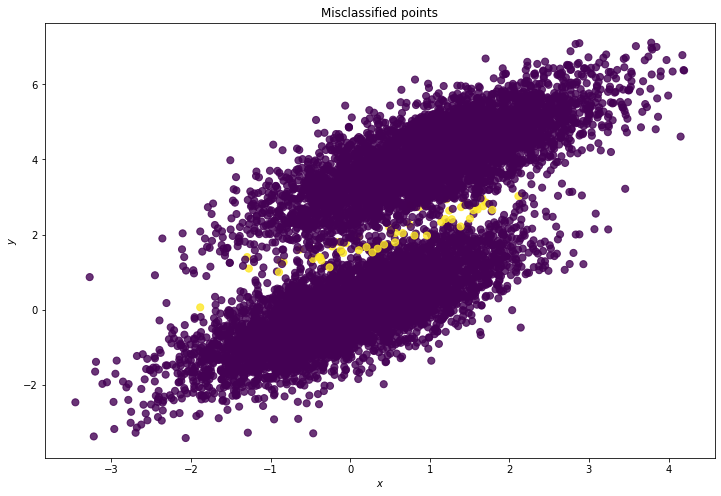

In [45]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.figure(figsize=(12, 8))
plt.scatter(x[:, 0], x[:, 1], c = pred!=l, alpha=.8, s=50)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Misclassified points")

## Bonus

In [38]:
from sklearn.model_selection import train_test_split

In [40]:
def loss_evolution(features, target, num_steps, learning_rate):
    """ 
    A modified `logistic_regression` function that returns the loss 
    over the training and test sets during the gradient descent.
    
    arg features: the whole samples array
    arg target: the whole label array
    arg num_steps: the number of iterations
    arg learning_rate: the descent speed
    
    return: two arrays containing loss values
    """
    ce_train = []
    ce_test = []
    
    features_intercept = add_intercept(features)
    X_train, X_test, y_train, y_test = train_test_split(features_intercept, 
                                                        target, 
                                                        test_size=0.2,
                                                        random_state=13)
    
    weights = np.zeros((features_intercept.shape[1], ))
    
    for step in range(num_steps):
        scores = np.dot(X_train, weights)
        predictions = sigmoid(scores)
        
        # Update weights 
        weights -= learning_rate * gradient(X_train, y_train, weights)
        
        # Print Loss every so often
        if step % 5000 == 0:
            ce_train.append(cross_entropy(X_train, y_train, weights))
            ce_test.append(cross_entropy(X_test, y_test, weights))
    
    return ce_train, ce_test

In [41]:
loss_train, loss_test = loss_evolution(x, l, num_steps=70000, 
                                       learning_rate=0.5)

In [42]:
step_list = np.arange(0, 70000, 5000)

Text(0, 0.5, 'Cross-entropy')

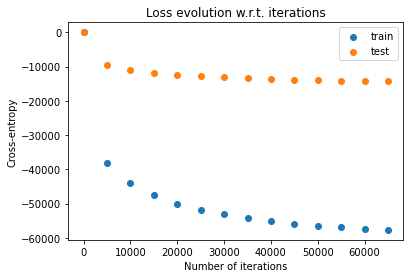

In [47]:
# Plot the loss
plt.scatter(step_list, loss_train, label="train")
plt.scatter(step_list, loss_test, label="test")
plt.legend()
plt.title("Loss evolution w.r.t. iterations")
plt.xlabel("Number of iterations")
plt.ylabel("Cross-entropy")

The loss on the test set stays relatively constant from $20000$ steps. Iterating further leads to overfitting the training set.

## Conclusion on the Logistic Regression

We built our own logistic regressor and used it to classify points from two nicely-separated distributions.